# Pytorch GAN MNIST Generator Sample Code

2020/05/02, Andy RK Chang v1.0 initial 



pytorch 生成 MNIST - GAN


https://clay-atlas.com/blog/2020/01/09/pytorch-chinese-tutorial-mnist-generator-discriminator-mnist/


github

https://github.com/ccs96307/PyTorch-GAN-Mnist/blob/master/mnist_train.py


In [9]:
# Read file from Google Drive

from google.colab import drive
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Build Model

In [0]:
# Class : model definition 

# -*- coding: utf-8 -*-
import torch.nn as nn

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Model Training

In [12]:
# -*- coding: utf-8 -*-
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import transforms

#from model import discriminator, generator

import numpy as np
import matplotlib.pyplot as plt

start_time = time.time()
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))


# Discriminator Loss => BCELoss
def d_loss_function(inputs, targets):
    return nn.BCELoss()(inputs, targets)


def g_loss_function(inputs):
    targets = torch.ones([inputs.shape[0], 1])
    targets = targets.to(device)
    return nn.BCELoss()(inputs, targets)


# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

# Model
G = generator().to(device)
D = discriminator().to(device)
print(G)
print(D)

# Settings
epochs = 200
lr = 0.0002
batch_size = 64
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_set = datasets.MNIST('mnist/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# Train
for epoch in range(epochs):
    epoch += 1

    for times, data in enumerate(train_loader):
        times += 1
        real_inputs = data[0].to(device)
        test = 255 * (0.5 * real_inputs[0] + 0.5)

        real_inputs = real_inputs.view(-1, 784)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        # Zero the parameter gradients
        d_optimizer.zero_grad()

        # Backward propagation
        d_loss = d_loss_function(outputs, targets)
        d_loss.backward()
        d_optimizer.step()

        # Generator
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)

        g_loss = g_loss_function(fake_outputs)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if times % 100 == 0 or times == len(train_loader):
            print('[{}/{}, {}/{}] D_loss: {:.3f}  G_loss: {:.3f}'.format(epoch, epochs, times, len(train_loader), d_loss.item(), g_loss.item()))

    imgs_numpy = (fake_inputs.data.cpu().numpy()+1.0)/2.0
    show_images(imgs_numpy[:16])
    plt.show()

    if epoch % 50 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')


print('Training Finished.')
print('Cost Time: {}s'.format(time.time()-start_time))


Output hidden; open in https://colab.research.google.com to view.

In [13]:
!pwd

/content


In [14]:
!ls

gdrive			 Generator_epoch_200.pth  sample_data
Generator_epoch_100.pth  Generator_epoch_50.pth
Generator_epoch_150.pth  mnist


# Predicitor

GPU State: cuda:0


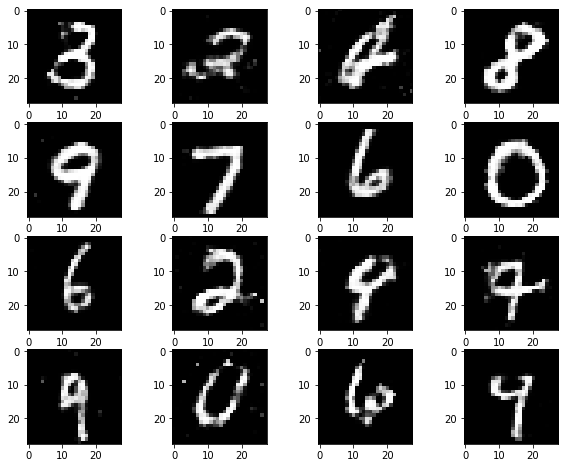

In [15]:
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

# Model
#G = torch.load('/content/gdrive/My Drive/Colab Notebooks/MNIST/Pytorch/PyTorch-GAN-Mnist-master/Generator_epoch_200.pth')
G = torch.load('Generator_epoch_200.pth')
G.eval()

# Generator
noise = (torch.rand(16, 128)-0.5) / 0.5
noise = noise.to(device)

fake_image = G(noise)
imgs_numpy = (fake_image.data.cpu().numpy()+1.0)/2.0
show_images(imgs_numpy)
plt.show()
